<center>
<h1>Development of MetPy’s Declarative Plotting Interface
<br>
<h3>13 July 2018
<br>
<br>
Ryan May (@dopplershift)
<br>
John Leeman (@geo_leeman)
<br><br>
UCAR/Unidata
</h3>
</center>

In [1]:
%matplotlib inline
from datetime import datetime
from traitlets import HasTraits, Unicode, Tuple, Int, List, Any, Union, Instance, Float, default, observe, link
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
import numpy as np
from metpy.cbook import is_string_like
from metpy.plots import ctables

proj_lookup = dict(lcc=ccrs.LambertConformal(central_latitude=40, central_longitude=-100,
                                             standard_parallels=[30, 60]))
garea_lookup = dict(us=(-115, -65, 25, 50))

class Map(HasTraits):
    garea = Unicode()
    proj = Union([Unicode(), Instance(ccrs.Projection)])
    plots = List(Any())
    figsize = Tuple(Int(), Int())
    layout = Tuple(Int(), Int())
    
    @default('layout')
    def default_layout(self):
        return (1, 1)

    @observe('plots')
    def _plots_changed(self, change):
        if hasattr(self, 'fig'):
            delattr(self, 'fig')
        for plot in change.new:
            plot.observe(self.refresh)

    def refresh(self, _):
        self.draw()
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        
    def draw(self):
        if not hasattr(self, 'fig'):
            self.fig = plt.figure(figsize=self.figsize)
            if is_string_like(self.proj):
                if self.proj == 'data':
                    proj = self.plots[0].griddata.metpy.cartopy_crs
                else:
                    proj = proj_lookup[self.proj]
            else:
                proj = self.proj
            nrow, ncol = self.layout
            self.ax = self.fig.add_subplot(nrow, ncol, 1, projection=proj)
        else:
            self.ax.cla()

        for p in self.plots:
            p.draw(self.ax)        

        self.ax.coastlines('50m', zorder=20)
        self.ax.add_feature(cfeat.STATES, zorder=20)

        if self.garea:
            if self.garea == 'global':
                self.ax.set_global()
            else:
                self.ax.set_extent(garea_lookup[self.garea], ccrs.PlateCarree())
        
        self.ax.set_title(', '.join(plot.name for plot in self.plots))
        return self.fig

    def __getitem__(self, ind):
        # TODO: Return particular axes
        pass

class Plot(HasTraits):
#    data = Any()
#    data = Instance(xr.Dataset)
    gfunc = Unicode()
    glevel = Int(allow_none=True, default_value=None)
    data_time = Instance(datetime, allow_none=True)

    @observe('gfunc')
    def _update_data(self, changed):
        self._griddata = self.data.metpy.parse_cf(changed.new)

    @property
    def griddata(self):
        return self._griddata

    @property
    def plotdata(self):
        subset = {'method': 'nearest'}
        if self.glevel is not None:
            subset[self.griddata.metpy.vertical.name] = self.glevel

        if self.data_time is not None:
            subset[self.griddata.metpy.time.name] = self.data_time

        imdata = self.griddata.sel(**subset)
        
        x = self.griddata.metpy.x
        y = self.griddata.metpy.y
        if 'degree' in x.units:
            X, Y = np.meshgrid(x, y)
            x, y, _ = self.griddata.metpy.cartopy_crs.transform_points(ccrs.PlateCarree(), X, Y).T
            x = x[:, 0] % 360
            y = y[0, :]
        
        return x, y, imdata

    @property
    def name(self):
        ret = self.gfunc
        if self.glevel is not None:
            ret += '@{:d}'.format(self.glevel)
        return ret
    
    @property
    def code(self):
        pass

class ImagePlot(Plot):
    ctable = Unicode()
    img_range = Tuple(Int(allow_none=True), Int(allow_none=True))

    @default('img_range')
    def default_img_range(self):
        return None, None

    def draw(self, ax):
        x, y, imdata = self.plotdata

        extents = (x.min(), x.max(), y.min(), y.max())
        origin = 'upper' if y[0] > y[-1] else 'lower'

        try:
            cmap = ctables.registry.get_colortable(self.ctable)
        except KeyError:
            cmap = plt.get_cmap(self.ctable)

        norm = plt.Normalize(*self.img_range)
        im = ax.imshow(imdata, extent=extents, origin=origin, cmap=cmap, norm=norm,
                       transform=self.griddata.metpy.cartopy_crs)
        #ax.figure.colorbar(im)

        
class ContourPlot(Plot):
    ctable = Unicode()
    img_range = Tuple(Int(allow_none=True), Int(allow_none=True))
    linecolor = Unicode('black')
    contours = Int(25)

    @default('img_range')
    def default_img_range(self):
        return None, None

    def draw(self, ax):
        x, y, imdata = self.plotdata
        im = ax.contour(x, y, imdata, self.contours, transform=self.griddata.metpy.cartopy_crs,
                        colors=self.linecolor, linewidths=2)

## The Problem: Weather Maps

* Meteorologists make maps

* Lots of maps

* So many maps
![weather map](./weather-map.png)

## Legacy Solution: GEMPAK

* GEneral Meteorological PacKage
* Command-line scripting of weather analysis
* Also some GUI applications
* Lots of plotting capabilities
* Lots of calculated parameters

![garp](./garp.gif)

![nmap](./nmap.gif)

![Trenberth Example](./us-trenberth.gif)

## GEMPAK: Now a new problem

* Started in the late 1980s
* Ancient technology stack (Motif????)
* Not flexible with data formats
* ***No longer in development by National Center for Environmental Prediction***

## MetPy

* Python toolkit for meteorology
* Provides file format support, plotting, and calculations
* Its mission in life is to ~~kill~~ gracefully replace GEMPAK

## GEMPAK Script

* Uses shell scripting and input redirection
* Declarative style (vs. Imperative style)

```sh
source /Users/gempak/GEMPAK6.3.0/Gemenviron
SET CURDAY = `date -u +%Y%m%d`
set FRUN = 12 

gdcntr <<EOF1
  GDFILE    = gfs/${CURDAY}${FRUN}_gfs003.gem
  GDATTIM   = 'f012'
  GLEVEL    = 700
  GVCORD    = pres
  CTYPE     = f
  GFUNC     = avor(wnd)
  CONTUR    = 2
  CINT      = 2
  LINE      = 1/1
  TITLE     = 31/-2/GFS ~
  GAREA     = us
  PROJ      = 'str/90;-100;0'
  DEVICE    = 'gif|us.gif|1024;768'
  r


e
EOF1
```

## Use Python!

* So clearly Python is a superior scripting solution here
* Just drop in Python and simplify!

<img src="./initial-python-code.png" alt="python code" width="400px"/>

* Well then.

* 43 lines of code (non-wrapped, no whitespace)
* About 30 different function and method calls

![computer smash](./beating_computer.gif)

* The Python stack is really powerful
* General functionality
* Requiring "real" programming makes it hard to introduce these tools early on in the curriculum

How can we make Python more like GEMPAK?

```sh
source /Users/gempak/GEMPAK6.3.0/Gemenviron
SET CURDAY = `date -u +%Y%m%d`
set FRUN = 12 

gdcntr <<EOF1
  GDFILE    = gfs/${CURDAY}${FRUN}_gfs003.gem
  GDATTIM   = 'f012'
  GLEVEL    = 700
  GVCORD    = pres
  CTYPE     = f
  GFUNC     = avor(wnd)
  CONTUR    = 2
  CINT      = 2
  LINE      = 1/1
  TITLE     = 31/-2/GFS ~
  GAREA     = us
  PROJ      = 'str/90;-100;0'
  DEVICE    = 'gif|us.gif|1024;768'
  r


e
```

```python
from datetime import date
today = date.today()
forecast = 12

proj = '...'
garea = 'us'
title = f'GFS {today:%Y%m%d}'

filename = f'gfs/{today:%Y%m%d}{forecast}_gfs003.gem'
datatime = 'f012'
gvcord = 'pres'
level = 700
interval = 2
gfunc = 'avor'
linestyle = 'solid'
outfile = 'us.png'
```

* Now this would seem to be using global variables...

* which would be an abomination
* But how about this:

```python
today = date.today()
forecast = 12

m = Map()
m.garea = 'us'
m.proj = 'data'
m.title = f'GFS {today:%Y%m%d}'

c = Contour()
c.data = xr.open_dataset(f'gfs/{today:%Y%m%d}{forecast}_gfs003.gem')
c.datatime = 'f012'
c.gvcord = 'pres'
c.level = 700
c.interval = 2
c.gfunc = 'avor'
c.linestyle = 'solid'

m.plots = [c]
m.savefig('us.png')
```

Now that looks nice in theory, but would it work in practice?

In [2]:
from siphon.catalog import TDSCatalog
import xarray as xr

gfs_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/'
                     'grib/NCEP/GFS/Global_0p5deg/catalog.xml')
gfs_data = xr.open_dataset(gfs_cat.latest.access_urls['OPENDAP'])

m = Map()
m.garea = 'us'
m.proj = 'data'
m.figsize = (10, 5)

cntr = ContourPlot()
cntr.data = gfs_data
cntr.gfunc = 'Geopotential_height_isobaric'
cntr.glevel = 50000
cntr.linecolor = 'tab:blue'
cntr.contours = 100
cntr.data_time = datetime.utcnow()

m.plots = [cntr]

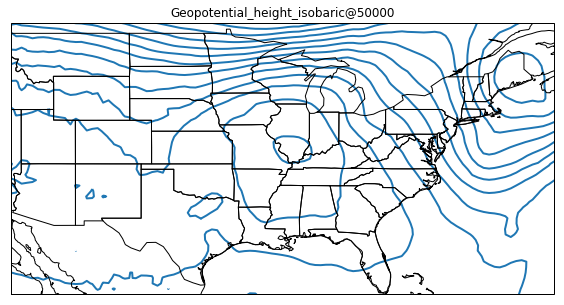

In [3]:
m.draw();

And we can add to it:

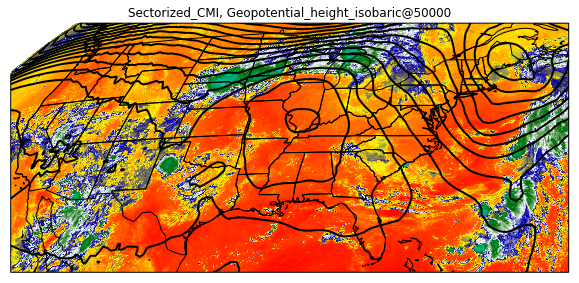

In [4]:
goes_cat = TDSCatalog('http://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/'
                      'GOES16/CONUS/Channel14/current/catalog.xml')
satdata = xr.open_dataset(goes_cat.datasets[-1].access_urls['OPENDAP'])

ps = ImagePlot()
ps.ctable = 'WVCIMSS_r'
ps.data = satdata
ps.gfunc = 'Sectorized_CMI' 

m.plots = [ps, cntr]
cntr.linecolor = 'black'
m.draw();

## What's powering this?
* Matplotlib, CartoPy (and of course MetPy)
* XArray and custom accessors to parse netCDF Climate and Forecasting (CF) metadata
* Traitlets

### Traitlets
* Attribute framework for IPython/Jupyter
* Validation
* Event notification
* Completely overkill for this...so far.

### Replacing GEMPAK tools
  * command line interface -> Use traitlets to load a "config"
    * provides validation
  * GUI interface -> notebook widgets

Brief JupyterLab Demo

## Wrapping up
* Implemented a declarative plotting syntax (borderline DSL) to mimic legacy functionality
* XArray works well as a data model for hiding some of the magic
* Traitlets 

## Future Work

* Migrate prototype to something we can ship
* Expand to additional plotting types
* Further development on notebook UI
* Command-line tool
* More features and capabilities from GEMPAK

# Acknowledgement

Kevin Goebbert (Valparaiso University) for helping inspire the direction of this work.

Unidata and this work are supported through grants NSF-1344155 and OAC-1740315.

For more information on MetPy, see: https://github.com/Unidata/MetPy